# Climate Change Belief Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textblob import TextBlob
import nltk 
import string
import re
%matplotlib inline

## Import Train and Test Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [11]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

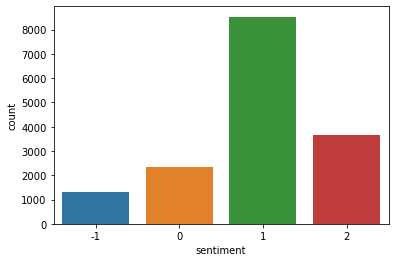

In [4]:
sns.countplot(x = 'sentiment', data = train)

## Data Cleaning and Text Preprocessing

In [5]:
def clean_message(message):
    message = re.sub(r'@[A-Za-z0-9]+','',message) ##Remove @aderate
    message = re.sub(r'#','',message) ##remove #hashtags
    message = re.sub(r'RT[\s]+', '', message) ## remove RT Retweets
    message = re.sub(r'https?:\/\/\S+', '', message) ##remove hyperlink
    message =  "".join([char for char in message if char not in string.punctuation]) ## remove puntuations i.e. ('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

    return message

In [6]:
def remove_emojis(message):
    regrex_pattern = re.compile(pattern = "["
      u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
         "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',message)

In [7]:
#Clean Data and add new column called cleaned_message
train['cleaned_message'] = train['message'].apply(clean_message)
train['cleaned_message'] = train['cleaned_message'].apply(remove_emojis)

### Get **Subjectivity** and ** Polarity**

In [8]:
#Get subjectivity
def get_subjectivity(message):
    return TextBlob(message).sentiment.subjectivity

#Get Polarity
def get_polarity(message):
    return TextBlob(message).sentiment.polarity

train['subjectivity'] = train['cleaned_message'].apply(get_subjectivity)
train['polarity'] = train['cleaned_message'].apply(get_polarity)



In [12]:
## plot word cloud (simply most used words in different sentiments)
believe = train[train['sentiment'] == 1]
no_belief = train[train['sentiment'] == -1]
neutral = train[train['sentiment'] == 0]
news = train[train['sentiment'] == 2]

allMessages = ' '.join([message for message in train['cleaned_message']])
message_belief = ' '.join(message for message in believe['cleaned_message'])
message_no_belief = ' '.join(message for message in no_belief['cleaned_message'])
message_neutral = ' '.join(message for message in neutral['cleaned_message'])
message_news = ' '.join(message for message in news['cleaned_message'])

fig, ax = plt.subplots(3, 1, figsize = (20, 20))

wordCloud_all = WordCloud(max_font_size=50, max_words=100, random_state= 42).generate(allMessages)

wordCloud_belief = WordCloud(max_font_size=50, max_words=100, random_state= 42).generate(message_belief)

wordCloud_no_belief = WordCloud(max_font_size=50, max_words=100, random_state= 42).generate(message_no_belief)

wordCloud_neutral = WordCloud(max_font_size=50, max_words=100, random_state= 42).generate(message_neutral)

wordCloud_news = WordCloud(max_font_size=50, max_words=100, random_state= 42).generate(message_news)

wordClouds = [wordCloud_all, wordCloud_belief, wordCloud_no_belief,wordCloud_neutral, wordCloud_news]

for i in range(len(wordClouds):
    ax[i].imshow(wordCloud_all, interpolation="bilinear")
    ax[i].set_title('All messages', fontsize = 30)
    ax[i].axis('off')

SyntaxError: invalid syntax (<ipython-input-12-98fd53839ba1>, line 27)

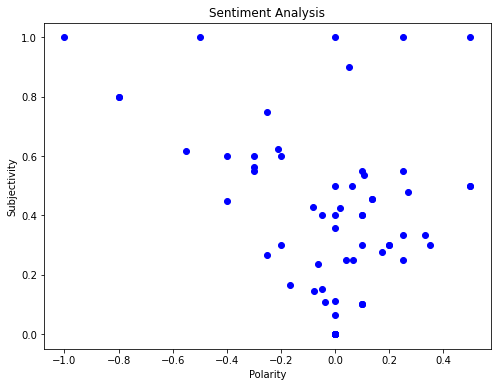

In [12]:
#plot polarity and Subjectivity

plt.figure(figsize=(8,6))
#Check for last 100 message
for i in range(15719, train.shape[0]):
    plt.scatter(train['polarity'][i], train['subjectivity'][i], color='Blue')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()